<a href="https://colab.research.google.com/github/sugarghost/hanghae99_AI_PLUS_2/blob/main/1_4_HOMEWORK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


## Test data 준비하기
    - Test data는 MNIST의 train data를 load하는 코드에서 `train=False`로 두면 됩니다.
    - Train data와 마찬가지로 test data에 대한 data loader를 생성해주시면 됩니다(batch size는 동일하게 적용).
        - Test data는 랜덤하게 섞일 필요가 없기 때문에 `shuffle=False`로 설정합니다.

In [ ]:
transform = transforms.ToTensor()

batch_size = 256

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
# [MY CODE] 테스트셋 준비
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False, # 테스트 데이터는 학습시키지 않음
    download=True,
    transform=transform
)

# [MY CODE] 테스트로더 준비
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False # 테스트 데이터는 섞을 필요 없음
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.53MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


## [MY CODE] 마지막에 ReLU 제거

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # [MY CODE] 마지막 단계에서는 ReLU 적용 안함
    x = self.layer3(x)

    return x


model = Model(28 * 28 * 1, 1024)

## `nn.CrossEntropyLoss` 적용하기
    - 변경되어야 할 점은 2가지로 i) `Model`의 최종 output의 dimension과 ii) `loss` 계산 부분입니다.

In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')
# [MY CODE] nn.CrossEntropyLoss 추가
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_accs, test_accs = [], []
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

## `nn.CrossEntropyLoss` 적용하기
    - 변경되어야 할 점은 2가지로 i) `Model`의 최종 output의 dimension과 ii) `loss` 계산 부분입니다.
## [LOG] 학습 과정에서의 Epoch별 손실값 및 정확도 출력

In [ ]:
n_epochs = 100
for epoch in range(n_epochs):
  total_loss = 0.

  # [MY CODE] Colab 부하가 심해서 모드를 분리하기로 함
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # MSE 방식 비활성화
    # loss = (preds[:, 0] - labels).pow(2).mean()
    loss = criterion(preds, labels) # [MY CODE] CrossEntropyLoss 적용
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # [MY CODE] 한번 돌려보니 부하가 오래 걸려서 평가 모드로 변경해서 처리
  with torch.no_grad():
    model.eval()
    # Epoch별 Train/Test 정확도 계산
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch:3d} | Loss: {total_loss} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch   0 | Loss: 538.9404816627502 | Train Acc: 0.1193 | Test Acc: 0.1177
Epoch   1 | Loss: 535.0102436542511 | Train Acc: 0.1779 | Test Acc: 0.1807
Epoch   2 | Loss: 530.9510803222656 | Train Acc: 0.2511 | Test Acc: 0.2568
Epoch   3 | Loss: 526.6289265155792 | Train Acc: 0.3658 | Test Acc: 0.3762
Epoch   4 | Loss: 521.9227628707886 | Train Acc: 0.4508 | Test Acc: 0.4567
Epoch   5 | Loss: 516.7158215045929 | Train Acc: 0.5010 | Test Acc: 0.5076
Epoch   6 | Loss: 510.84736227989197 | Train Acc: 0.5422 | Test Acc: 0.5444
Epoch   7 | Loss: 504.1905462741852 | Train Acc: 0.5766 | Test Acc: 0.5766
Epoch   8 | Loss: 496.5628046989441 | Train Acc: 0.6029 | Test Acc: 0.6036
Epoch   9 | Loss: 487.885169506073 | Train Acc: 0.6269 | Test Acc: 0.6305
Epoch  10 | Loss: 477.8703008890152 | Train Acc: 0.6466 | Test Acc: 0.6502
Epoch  11 | Loss: 466.4352878332138 | Train Acc: 0.6635 | Test Acc: 0.6667
Epoch  12 | Loss: 453.44530844688416 | Train Acc: 0.6789 | Test Acc: 0.6814
Epoch  13 | Loss: 438.92

## [MY CODE] 결과 테스트를 위한 출력

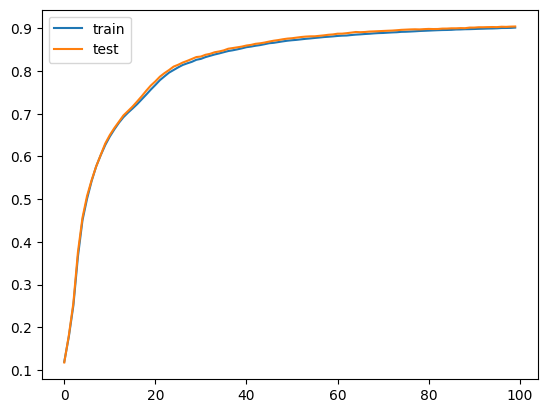

In [ ]:
plot_acc(train_accs, test_accs)
